In [16]:
# KEGG Pathways Overlap Project (Python version)

# import requests to allow us to make http requests to the kegg api
import requests
# import pandas to create dataframes for easy data manipulation
import pandas as pd
# import combinations from itertools to create all possible pairs of pathways
from itertools import combinations
# import defaultdict to handle dictionary creation with default values
from collections import defaultdict
# import pyplot from matplotlib to generate and save the venn diagram
from matplotlib import pyplot as plt

### AI Disclaimer

*   **Question 1**: `line.split("\t")[:2]`, `.apply(extract_symbol)`,`.drop_duplicates(subset=["PATHWAY_ID", "GENE_ID"])`,`.nunique()` (used for better output view), and use AI to debug the code and added `gene2pw["PATHWAY_ID"] = gene2pw["PATHWAY_ID"].str.replace("path:", "", regex=False)`
*   **Question 2**: AI gives advice for `pathway2name`
*   **Question 3**: for  `if overlap: overlap = overlap.reset_index().to_csv("overlap.csv", index=False)` used AI for helps, and also used AI for creating files.
*   **Question 4**: `.reset_index()` and `.to_csv()` (Reference: [pandas.DataFrame.to_csv](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html))
*   **Question 5**: `f.write` and `if not common` logic
*   **Question 6**: `try: except:` block and `venn3()` diagram (Reference: [matplotlib-venn](https://pypi.org/project/matplotlib-venn/))
*   **Question 7**: And since this is package creatating process before professor taught the package lecture, so I use AI to help me with debug and template formating and also with the overall essential file needed for package. Also the documentation website is also ask help for AI, but I provide the context let AI do the debug and file formating. 

In [28]:
url_pathways = "http://rest.kegg.jp/list/pathway/hsa"
url_gene2pw  = "http://rest.kegg.jp/link/pathway/hsa"
url_geneinfo = "http://rest.kegg.jp/list/hsa"

# use requests.get() to retrieve data from the url, then .text to get content, and .splitlines() to break it into a list of lines
pathways_raw = requests.get(url_pathways).text.strip().splitlines()
gene2pw_raw  = requests.get(url_gene2pw).text.strip().splitlines()
geneinfo_raw = requests.get(url_geneinfo).text.strip().splitlines()

# use pd.dataframe() to convert the list of lists into a structured table
# use .split("\t") to separate each line by tab characters
pathways = pd.DataFrame(
    [line.split("\t")[:2] for line in pathways_raw],
    columns=["PATHWAY_ID", "PATHWAY_NAME"]
)

# parse Gene to Pathway map
# again use pd.dataframe() to structure the gene-pathway mapping data
gene2pw = pd.DataFrame(
    [line.split("\t")[:2] for line in gene2pw_raw],
    columns=["GENE_ID", "PATHWAY_ID"]
)

#normalize pathway IDs to match pathways table
gene2pw["PATHWAY_ID"] = gene2pw["PATHWAY_ID"].str.replace("path:", "", regex=False)


#parse Gene Info (ID, TYPE, TYPE_DESC, INFO)
parsed_geneinfo = []
for line in geneinfo_raw:
    parts = line.split("\t")
    # use a while loop to append empty strings if columns are missing, ensuring data consistency
    while len(parts) < 4:
        parts.append("")   # pad missing columns
    parsed_geneinfo.append(parts[:4])

# create the geneinfo dataframe from the parsed list
geneinfo = pd.DataFrame(
    parsed_geneinfo,
    columns=["GENE_ID", "TYPE", "TYPE_DESCRIPTION", "GENE_INFO"]
)

In [31]:
#(1)
    # "RNR1, MTRNR1, MT-RNR1; s-rRNA" -> "RNR1"
    # use .split() twice to isolate the first gene symbol before the comma and semicolon
def extract_symbol(ginfo):
    if pd.isna(ginfo) or ginfo == "":
        return None
    return ginfo.split(",")[0].split(";")[0].strip()

# use .apply() to run the extract_symbol function on every row of the 'gene_info' column
geneinfo["GENE_SYMBOL"] = geneinfo["GENE_INFO"].apply(extract_symbol)
# filter the dataframe to keep only the 'gene_id' and 'gene_symbol' columns
geneinfo = geneinfo.dropna(subset=["GENE_SYMBOL"])

In [32]:
# (1) Map and merge by PATHWAY_ID and GENE_ID
mapping = (
    # use .merge() to join gene2pw with geneinfo on 'gene_id' to add gene symbols
    gene2pw
    .merge(geneinfo, on="GENE_ID", how="inner")   
    # use .merge() again to join with pathways on 'pathway_id' to add pathway names   
    .merge(pathways, on="PATHWAY_ID", how="inner")   
    # use .drop_duplicates() to ensure each gene-pathway pair is unique        
    # ensure each gene appears only once per pathway
    .drop_duplicates(subset=["PATHWAY_ID", "GENE_ID"])
)

mapping["GENE_SYMBOL"] = mapping["GENE_SYMBOL"].str.upper()
# use .nunique() to count the number of unique pathways and genes in our mapped data
print(f"Pathways: {mapping['PATHWAY_ID'].nunique()}")
print(f"Genes: {mapping['GENE_SYMBOL'].nunique()}")

mapping.head()

Pathways: 369
Genes: 8671


,GENE_ID,PATHWAY_ID,TYPE,TYPE_DESCRIPTION,GENE_INFO,GENE_SYMBOL,PATHWAY_NAME
0,hsa:10327,hsa00010,CDS,1:45550826..45570049,"AKR1A1, ALDR1, ALR, ARM, DD3, HEL-S-6; aldo-ke...",AKR1A1,Glycolysis / Gluconeogenesis - Homo sapiens (h...
1,hsa:124,hsa00010,CDS,4:complement(99276369..99290985),"ADH1A, ADH1; alcohol dehydrogenase 1A (class I...",ADH1A,Glycolysis / Gluconeogenesis - Homo sapiens (h...
2,hsa:125,hsa00010,CDS,4:complement(99304971..99321401),"ADH1B, ADH2, HEL-S-117; alcohol dehydrogenase ...",ADH1B,Glycolysis / Gluconeogenesis - Homo sapiens (h...
3,hsa:126,hsa00010,CDS,4:complement(99336497..99352746),"ADH1C, ADH3; alcohol dehydrogenase 1C (class I...",ADH1C,Glycolysis / Gluconeogenesis - Homo sapiens (h...
4,hsa:127,hsa00010,CDS,4:complement(99123658..99144297),"ADH4, ADH-2, HEL-S-4; alcohol dehydrogenase 4 ...",ADH4,Glycolysis / Gluconeogenesis - Homo sapiens (h...


In [ ]:
# (2) Compute pairwise pathway overlaps for package preparation
print("Computing pathway overlaps...")

# use .groupby() to group genes by pathway, then apply(set) to get a set of genes for each pathway
pathway2genes = mapping.groupby("PATHWAY_ID")["GENE_SYMBOL"].apply(set).to_dict()
# create a lookup dictionary for pathway names using zip()
pathway2name = (
    mapping[["PATHWAY_ID", "PATHWAY_NAME"]]
    .drop_duplicates()
    .set_index("PATHWAY_ID")["PATHWAY_NAME"]
    .to_dict()
)


#(3) compute overlaps
records = []
# use combinations() to iterate through every possible pair of pathways
for p1, p2 in combinations(pathway2genes.keys(), 2):
    # use .intersection() to find genes present in both pathway sets
    overlap = pathway2genes[p1].intersection(pathway2genes[p2])
    if overlap:
        records.append({
            "PATHWAY_ID1": p1,
            "PATHWAY_NAME1": pathway2name.get(p1, ""),
            "PATHWAY_ID2": p2,
            "PATHWAY_NAME2": pathway2name.get(p2, ""),
            "NUMBER_OF_OVERLAPPING_GENES": len(overlap),
            "LIST_OF_OVERLAPPING_GENES": ";".join(sorted(overlap))
        })

# create a dataframe from the results and use .sort_values() to rank by overlap size
crosstalk = pd.DataFrame(records)
crosstalk = crosstalk.sort_values("NUMBER_OF_OVERLAPPING_GENES", ascending=False)
# use .to_csv() to save the results to a file
crosstalk.to_csv("KEGG_crosstalk.csv", index=False)
print(f"Saved KEGG_crosstalk.csv ({len(crosstalk)} pairs)")

Computing pathway overlaps...
Saved KEGG_crosstalk.csv (23090 pairs)


In [ ]:
# (4) Rank genes by # of pathways
gene_rank = (
    # use .groupby() on gene symbols to aggregate data by gene
    mapping.groupby("GENE_SYMBOL")["PATHWAY_ID"]
           # use .nunique() to count how many unique pathways each gene belongs to
           .nunique()
           # use .reset_index() to convert the series back to a dataframe
           .reset_index(name="NUM_PATHWAYS")
           # use .sort_values() to order genes from most pathways to least
           .sort_values("NUM_PATHWAYS", ascending=False)
)
gene_rank.to_csv("gene_rank.csv", index=False)
print("Saved gene_rank.csv")

Saved gene_rank.csv


In [ ]:
# (5) Common pathways for top 4 genes
# use .head(4) to get the top 4 genes
top_genes = gene_rank.head(4)["GENE_SYMBOL"].tolist()
gene2path = mapping.groupby("GENE_SYMBOL")["PATHWAY_ID"].apply(set).to_dict()

sets = [gene2path[g] for g in top_genes]
# use set.intersection() with * unpacking to find pathways common to all top genes
common = set.intersection(*sets)

if not common:
    # fallback to top 3 if no common pathways found
    top_genes = gene_rank.head(3)["GENE_SYMBOL"].tolist()
    sets = [gene2path[g] for g in top_genes]
    common = set.intersection(*sets)

with open("top_genes_common_pathways.txt", "w") as f:
    f.write("Top genes used: " + ", ".join(top_genes) + "\n")
    f.write(f"Common pathways ({len(common)}):\n")
    f.write("\n".join(sorted(common)))
print("Saved top_genes_common_pathways.txt"

Saved top_genes_common_pathways.txt


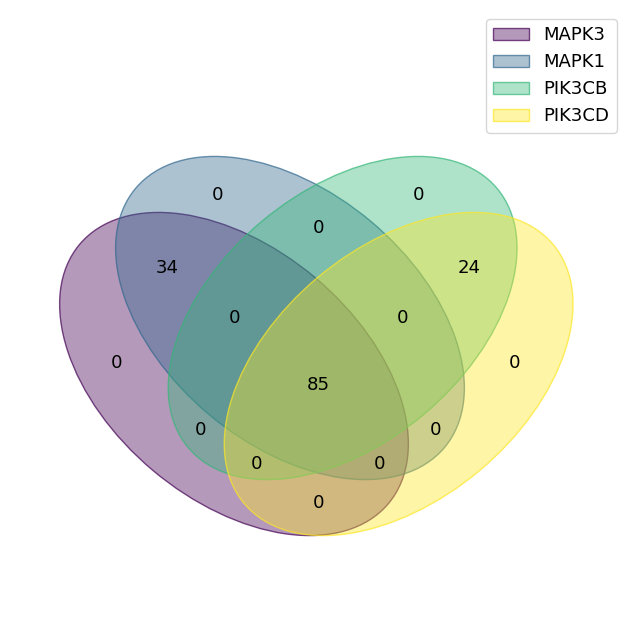

In [ ]:
# (6) Venn diagram
try:
    from venn import venn
    gene_sets_dict = {g: sets[i] for i, g in enumerate(top_genes)}
    # use venn() to plot the diagram if the package is available
    venn(gene_sets_dict)
except ImportError:
    print("Package 'venn' not installed — showing top 3-set fallback.")
    from matplotlib_venn import venn3
    # use venn3() as a fallback to plot a 3-circle venn diagram
    venn3(subsets=sets[:3], set_labels=top_genes[:3])
